# Random Forest

## Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings

In [2]:
warnings.filterwarnings('ignore')

## Data Import

In [3]:
! ls ./Bot_Iot_Data_File/Entire_Dataset/

UNSW_2018_IoT_Botnet_Dataset_1.csv
UNSW_2018_IoT_Botnet_Dataset_2.csv
UNSW_2018_IoT_Botnet_Dataset_3.csv
UNSW_2018_IoT_Botnet_Dataset_Feature_Names.csv
UNSW_2018_IoT_Botnet_Final_10_Best.csv


In [4]:
data = pd.read_csv("./Bot_Iot_Data_File/Entire_Dataset/UNSW_2018_IoT_Botnet_Final_10_Best.csv", sep=';', index_col = 0)

## Feature와 Target 설정
Feature는 joint함수를 활용하여 설정

In [5]:
best_cols = ['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']
target_col = ['category']

In [6]:
data = data[best_cols + target_col]
data = data.sample(50000)

In [7]:
data.head(5)

,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,category
1224366,82778,1.810523,100,0.000000,4,2.216011,100,0.0,0.215623,3.809488,DoS
2636688,8072,0.466016,100,3.994508,4,4.339362,100,0.0,0.838204,4.998170,DDoS
2335535,159996,1.541501,100,0.000000,3,2.174568,100,0.0,0.310989,3.395187,DDoS
1506232,102490,0.037442,100,4.780601,4,4.813334,100,0.0,0.624669,4.876342,DoS
2487287,49600,1.252331,100,0.000000,3,1.252331,100,0.0,0.050593,2.504662,DDoS


In [8]:
X_orig = data.drop(columns = target_col)
y = data[target_col]
y = np.ravel(y)
y

array(['DoS', 'DDoS', 'DDoS', ..., 'DDoS', 'DDoS', 'DDoS'], dtype=object)

## 데이터 전처리 및 정규화

### Target이 범주형 데이터이므로 LabelEncoder사용

In [9]:
le = LabelEncoder()
y = le.fit_transform(y)

### Feature들은 수치형 데이터이므로 StandardScaler 사용

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_orig)
X_scaled = scaler.transform(X_orig)
X = pd.DataFrame(X_scaled, columns=best_cols)

### Train & Test 분리

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest 학습

In [12]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5,random_state=42)
rf.fit(X_train,y_train)
predict1 = rf.predict(X_test)
print(accuracy_score(y_test,predict1))

0.9682666666666667


In [13]:
# rf.get_params()

## Feature의 중요도 

In [14]:
rf.feature_importances_

array([0.0200437 , 0.08696615, 0.07460248, 0.05707198, 0.12543486,
       0.0461565 , 0.25101137, 0.00370466, 0.25900439, 0.0760039 ])

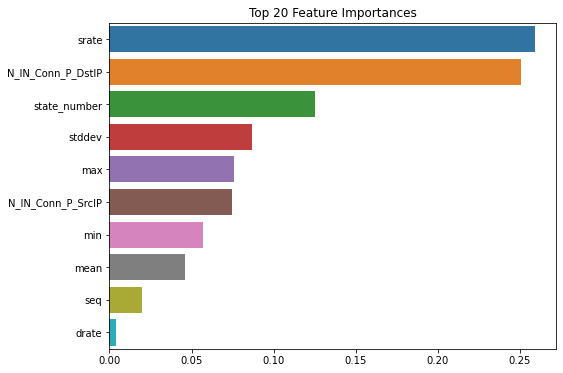

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### GridSearchCV를 통한 최적의 파라미터 계산

In [16]:
params = { 'n_estimators' : list(range(0, 50, 10)),
           'max_depth' : list(range(0, 20, 5)),
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 15, 'n_estimators': 40}
최고 예측 정확도: 0.9971


### RandomizedSearchCV를 통한 최적의 파라미터 계산

In [17]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['sqrt', 'log2']
max_depth = [2,4, 6, 8]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [18]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [19]:
rf_Model = RandomForestClassifier()

In [20]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [21]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [22]:
param_score = pd.DataFrame(rf_RandomGrid.cv_results_).sort_values('rank_test_score')
param_score[param_score.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,1.043868,0.028193,0.011885,0.00013,41,2,2,log2,8,True,...,0.991143,0.99,0.985714,0.989429,0.987143,0.984286,0.986571,0.987543,0.001984,1
